## Surrogate Assisted Evolutionary Algorithms for CNN Hyperparameter Optimization

### Imports

In [1]:
from util import AlexNet, SmallCNN, get_loaders, train_model
from es import *
import oapackage

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import pickle
import os
import torch

### CNN Hyperparameters

In [2]:
# CNN Hyperparameters
DATA_DIR = '~/data'
DATASET = 'cifar'
BATCH_SIZE = 128
NUM_CLASSES = 10
NUM_EPOCHS = 10
VALIDATION_TARGET = 100 # target validation accuracy
TRAIN_CONCURRENT = 5 # number of models to train concurrently
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Create a curated training population using hyperparameters close to default and recommended values

In [3]:
# check if saved file exists
if os.path.exists('curated_training_population.pkl'):
    with open('curated_training_population.pkl', 'rb') as f:
        training_population1 = pickle.load(f)
else:

    # Curated hyperparameters
    lrs = [0.01, 0.001, 0.0001]
    momentums = [0.9, 0.99, 0]
    weight_decays = [0.0005, 0.0001, 0]

    # Create a list of hyperparameter combinations
    hyperparams = []
    for lr in lrs:
        for momentum in momentums:
            for weight_decay in weight_decays:
                hyperparams.append((lr, momentum, weight_decay))

    # create training population from hyperparams
    training_population1 = [Genome(x=hyperparam) for hyperparam in hyperparams]

    # Update fitnesses using multiprocessing   
    x_values = [genome.x for genome in training_population1]
    with ProcessPoolExecutor(TRAIN_CONCURRENT) as executor:
        results = list(tqdm(executor.map(fitness, training_population1), total=len(training_population1)))

    for i in range(len(training_population1)):
        training_population1[i].valid_acc = results[i][0]
        training_population1[i].train_acc = results[i][1]
        training_population1[i].train_loss = results[i][2]
        training_population1[i].loss_target_fitness = results[i][3]

    # save the population to a file
    with open('curated_training_population.pkl', 'wb') as f:
        pickle.dump(training_population1, f)

Create a random training population using uniform distributions for each hyperparameter (via default Genome constructor)

In [4]:
# check if saved file exists
if os.path.exists('random_training_population.pkl'):
    with open('random_training_population.pkl', 'rb') as f:
        training_population2 = pickle.load(f)
else:
    
    # Initialize population creation
    training_population2 = [Genome() for _ in range(100)]

    # Update fitnesses using multiprocessing   
    x_values = [genome.x for genome in training_population2]
    with ProcessPoolExecutor(TRAIN_CONCURRENT) as executor:
        results = list(tqdm(executor.map(fitness, training_population2), total=len(training_population2)))

    # update the population with the results
    for i in range(len(training_population2)):
        training_population2[i].valid_acc = results[i][0]
        training_population2[i].train_acc = results[i][1]
        training_population2[i].train_loss = results[i][2]
        training_population2[i].loss_target_fitness = results[i][3]

    # save the population to a file
    with open('random_training_population.pkl', 'wb') as f:
        pickle.dump(training_population2, f)


Combine population and create visualizations

In [5]:
# combine the two populations
population = training_population1 + training_population2

In [6]:
# mean population validation accuracy
mean_valid_acc = np.mean([genome.valid_acc for genome in population])
print('Mean population validation accuracy: {}'.format(mean_valid_acc))

# mean population training accuracy
mean_train_acc = np.mean([genome.train_acc for genome in population])
print('Mean population training accuracy: {}'.format(mean_train_acc))

# mean population training loss
mean_train_loss = np.mean([genome.train_loss for genome in population])
print('Mean population training loss: {}'.format(mean_train_loss))

# mean population loss target fitness
mean_loss_target_fitness = np.mean([genome.loss_target_fitness for genome in population])
print('Mean population loss target fitness: {}'.format(mean_loss_target_fitness))

# max population validation accuracy
max_valid_acc = np.max([genome.valid_acc for genome in population])
print('Max population validation accuracy: {}'.format(max_valid_acc))

# max population training accuracy
max_train_acc = np.max([genome.train_acc for genome in population])
print('Max population training accuracy: {}'.format(max_train_acc))

# max population training loss
max_train_loss = np.max([genome.train_loss for genome in population])
print('Max population training loss: {}'.format(max_train_loss))

# max population loss target fitness
max_loss_target_fitness = np.max([genome.loss_target_fitness for genome in population])
print('Max population loss target fitness: {}'.format(max_loss_target_fitness))


Mean population validation accuracy: 37.30055016795481
Mean population training accuracy: 39.59373134703148
Mean population training loss: 1.3150466028160936
Mean population loss target fitness: 32.9878969732364
Max population validation accuracy: 73.66999816894531
Max population training accuracy: 88.12999725341797
Max population training loss: 2.327260732650757
Max population loss target fitness: 91.71355498721228


Find and visualize the pareto front

Pareto: 4 optimal values, 4 objects


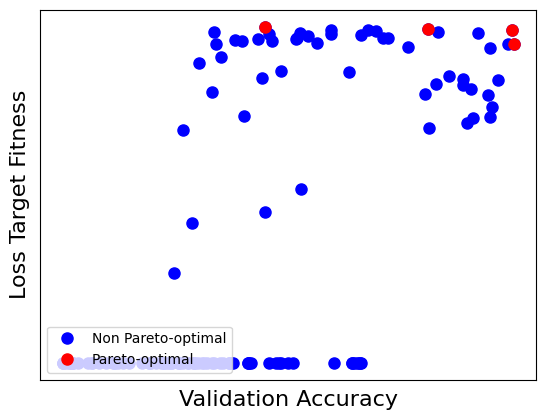

In [7]:
# find the pareto front
pareto=oapackage.ParetoDoubleLong()

for ii in range(0, len(population)):
    w=oapackage.doubleVector( (population[ii].valid_acc, population[ii].loss_target_fitness))
    pareto.addvalue(w, ii)

# show the pareto front size 
pareto.show(verbose=1)

# show the pareto front visualization
pareto_front = [population[i] for i in pareto.allindices()]
h=plt.plot([genome.valid_acc for genome in population], [genome.loss_target_fitness for genome in population], '.b', markersize=16, label='Non Pareto-optimal')
h=plt.plot([genome.valid_acc for genome in pareto_front], [genome.loss_target_fitness for genome in pareto_front], '.r', markersize=16, label='Pareto-optimal')
plt.xlabel('Validation Accuracy', fontsize=16)
plt.ylabel('Loss Target Fitness', fontsize=16)
plt.xticks([])
plt.yticks([])
_=plt.legend(loc=3, numpoints=1)